# Time Series Forecasting: Predicting Stock Price of INDF

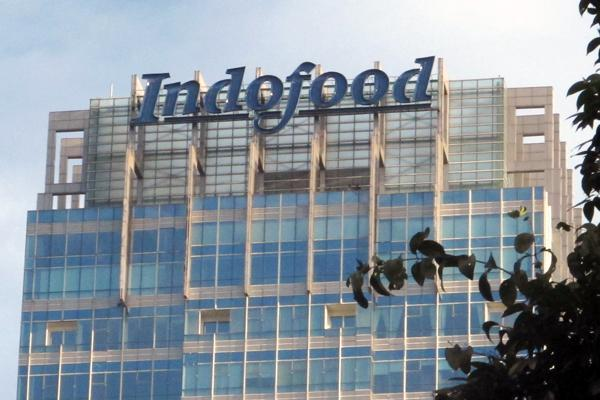

## Business Problem Understanding

### Background

PT Indofood Sukses Makmur Tbk. (ticker: **INDF.JK**) is a prominent consumer goods company listed on the Indonesia Stock Exchange (IDX). Given Indonesia’s growing economy and the significance of the consumer goods sector, many investors and market analysts closely monitor INDF’s stock price movements. Accurately predicting the future price of **INDF.JK** is essential for various stakeholders—ranging from retail investors aiming to optimize their portfolios to institutional investors seeking to manage risk and allocate assets effectively.

However, forecasting a stock price involves navigating a complex landscape influenced by numerous factors, including but not limited to: market sentiment, macroeconomic indicators, competitive dynamics, and company-specific events. Furthermore, price fluctuations can happen rapidly, reflecting global market conditions and investor behavior. This complexity highlights the need for a robust forecasting model capable of capturing the underlying trends and seasonality in the time series data.

### Problem Statement
One of the most pressing challenges in financial markets is developing an accurate method for forecasting future stock prices. The dynamic nature of stock markets, shaped by both intrinsic company performance and extrinsic economic conditions, makes prediction tasks notably difficult. For investors focused on **INDF.JK**, an inaccurate forecast can translate into suboptimal decisions, potential financial losses, and missed opportunities. Consequently, establishing a reliable approach to time series forecasting is critical to mitigate risks and improve overall decision-making quality.

### Goals
The primary objective of this analysis is to **design and implement a time series forecasting model that can predict the future price of INDF.JK with a high degree of accuracy**. By doing so, we aim to:

- Assist individual and institutional investors in making better-informed trading or investment decisions.
- Provide an analytical tool for portfolio managers to optimize asset allocation and manage risk effectively.
- Offer insights into market patterns and trends, contributing to a deeper understanding of the stock’s behavior in varying market conditions.

### Analytical Approach
To achieve these goals, the following steps will be undertaken:

1. Data Collection and Exploration
    - Gather historical stock price data for **INDF.JK**, including daily closing prices, trading volumes, and other relevant features using python web scraping

2. Model Development
    - Utilize various time series forecasting techniques (e.g., **ARIMA**, **SARIMA**, and **Prophet**).
    - Perform hyperparameter tuning and model selection to identify the best-performing approach.

3. Validation and Testing
    - Split the dataset into training, validation, and test sets to evaluate model performance objectively.
    - Compare forecast accuracy across different models to ensure that the final model aligns with business needs.

### Metric Evaluation

For stock price forecasting, the following metrics will be used to evaluate model performance:

- **RMSE (Root Mean Squared Error)**: Provides a measure of the magnitude of errors by taking the square root of the average squared differences between the predicted and actual stock prices.
- **MAE (Mean Absolute Error)**: Reflects the average absolute deviation of the model’s predictions from the actual prices, offering an intuitive measure of forecast accuracy.
- **MAPE (Mean Absolute Percentage Error)**: Expresses prediction errors as a percentage of actual values, making it easier to compare forecasting performance across different scales.

Lower values of RMSE, MAE, and MAPE indicate a more accurate model for predicting **INDF.JK** stock prices. Because these metrics capture how close the predictions are to the actual prices, they are most relevant for assessing model performance in terms of stock price prediction.

## Library

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
import itertools
from itertools import product

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

# yahoo finance api
import yfinance as yf

# forecasting libraries
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.diagnostics import cross_validation, performance_metrics

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterSampler

## Dataset

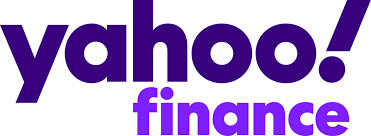

The stock dataset will be scraped from [yahoo finance](https://finance.yahoo.com/) using the `yfinance` python package.

In [2]:
# Define the ticker symbol
ticker = 'INDF.JK'

# Download the historical stock data from Yahoo Finance
data = yf.download(ticker, start='2021-01-01', end='2023-12-31')

# The downloaded DataFrame has the date as its index and columns: Open, High, Low, Close, Adj Close, Volume
# We filter to keep only the "Close" column. Since the date is in the index, we'll reset it to a column.
flattened_data = data[['Close']].reset_index()
flattened_data.columns = ['Date', 'Close']

# Display the first few rows of the filtered DataFrame
print("First 5 rows of the data (Date and Stock Closing Price):")
display(flattened_data.head())

[*********************100%***********************]  1 of 1 completed

First 5 rows of the data (Date and Stock Closing Price):


,Date,Close
0,2021-01-04,5791.897461
1,2021-01-05,5813.112793
2,2021-01-06,5728.250977
3,2021-01-07,5749.466797
4,2021-01-08,5770.682129


The resulting dataset will be saved to a `.csv` file for further analysis.

In [3]:
# Save the filtered DataFrame to a CSV file
csv_filename = f"{ticker[:4]}.csv"
flattened_data.to_csv(csv_filename, index=False)
print(f"\nStock price data saved to '{csv_filename}'")


Stock price data saved to 'INDF.csv'


## Exploratory Data Analysis (EDA)

To understand the data better, several visualizations will be created from the `INDF.csv` dataset

In [4]:
df = pd.read_csv('INDF.csv')

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create a line chart using Plotly
fig = px.line(df, x='Date', y='Close', title='INDF Stock Price over Time')

# Show the plot
fig.show()

**Insight:** INDF stock price data shows observable **multiplicative seasonal patterns** over the years, which can be exploited to forecast stock prices.

In [5]:
# Create box plot
fig_box = px.box(df, y='Close', title='Box Plot of INDF Stock Price')

# Show the plot
fig_box.show()

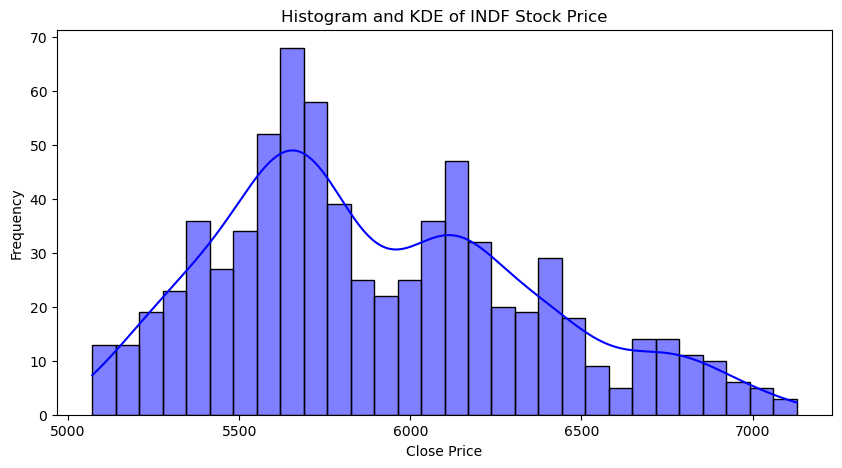

In [6]:
# Set figure size
plt.figure(figsize=(10, 5))

# Histogram & KDE Plot
sns.histplot(df['Close'], kde=True, bins=30, color='blue')
plt.title('Histogram and KDE of INDF Stock Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

**Insight**: Both boxplot and histogram (with KDE line) shows a right-skewed distribution, which indicates that INDF stock price has trended upward.

## Timeseries Forecasting with `Prophet` Model

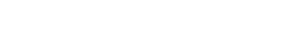

First released in 2017 by Meta (previously Facebook) after the publication of [Forecasting at Scale](https://peerj.com/preprints/3190/) as part of Meta's [open source software](https://opensource.fb.com/) initiative, `Prophet` has become the premier go-to python package to forecast time series due to its robust additive model that can handle outliers, missing data, and trend shifts.

The `Prophet` model main mathematical formula is written thusly:

$$ y(t) = g(t) + s(t) + h(t) + \varepsilon_t $$

- Trend $g(t)$: non-periodic changes in the value of the time series,
- Seasonality $s(t)$: periodic changes (e.g., weekly and yearly seasonality),
- Holidays $h(t)$: effects of holidays which occur on potentially irregular schedules over one or more days,
- Error $\varepsilon_t$: represents any idiosyncratic changes which are not accommodated by the model.

This notebook shall implement several features of `Prophet` package such as adding holidays/special events (i.e. dividend dates) and adjusting for seasonality effect, to name a few.

### Dataset Loading & Preprocessing

Firstly, the dataset is loaded and simultaneously undergoes several preprocessing steps to ensure that it has the correct column names and data types to be processed further by Prophet.

In [7]:
# load the dataset
df = pd.read_csv('INDF.csv')

# convert and rename columns for Prophet
df['Date'] = pd.to_datetime(df['Date'])
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
df

,ds,y
0,2021-01-04,5791.897461
1,2021-01-05,5813.112793
2,2021-01-06,5728.250977
3,2021-01-07,5749.466797
4,2021-01-08,5770.682129
...,...,...
727,2023-12-21,6004.770020
728,2023-12-22,6004.770020
729,2023-12-27,6076.540039
730,2023-12-28,6172.233887


### Splitting the Dataset

The dataset will be split into two data sets: train and test dataset:
- Training dataset will include data from February 2021 to December 2022
- Testing dataset will include data from January 2023 to January 2024

In [8]:
# Split into train-test sets
train = df[:-239]
test = df[-239:]
display(train.tail(), test.head())

,ds,y
488,2022-12-26,6351.979980
489,2022-12-27,6282.686035
490,2022-12-28,6213.391113
491,2022-12-29,6282.686035
492,2022-12-30,6213.391113


,ds,y
493,2023-01-02,6259.587891
494,2023-01-03,6236.489746
495,2023-01-04,6328.881836
496,2023-01-05,6328.881836
497,2023-01-06,6421.274414


### Creating Holiday Dataframe


`Prophet` package includes `make_holidays_df` function to account for national holidays/special dates (such as annual shareholders' meeting or cum dividend dates) that can be added into the model.

The cells below will create a `holidays` dataframe which will be added to the `Prophet` model.

In [9]:
def create_holidays(country, special_dates):
    country_holidays = make_holidays_df(year_list=list(range(2021, 2024)), country=country)
    special_events = pd.DataFrame({'holiday': 'corp_action', 'ds': pd.to_datetime(special_dates)})
    holidays = pd.concat([country_holidays, special_events], ignore_index=True).sort_values(by=['ds'])
    return holidays

In [10]:
special_dates = ['2021-09-06', '2022-07-22', '2022-08-01', '2023-06-23', '2023-07-06']

In [11]:
holidays = create_holidays(country='ID', special_dates=special_dates)
display(holidays.head(), holidays.tail())

,ds,holiday
0,2021-01-01,New Year's Day
13,2021-02-12,Lunar New Year
7,2021-03-11,Isra' and Mi'raj
11,2021-03-14,Day of Silence
10,2021-04-02,Good Friday


,ds,holiday
52,2023-07-06,corp_action
40,2023-07-19,Islamic New Year
33,2023-08-17,Independence Day
41,2023-09-28,Prophet's Birthday
34,2023-12-25,Christmas Day


### Modelling


After conducting those pre-processing steps, a `Prophet` model will be instantiated and fitted on the training dataset without conducting hyperparameter tuning.

Some parameters used include:
- `seasonality_mode` = Mode of seasonality (either 'additive' or 'multiplicative').
- `changepoint_prior_scale` = Regularization for trend changepoints (higher values allow more flexibility).
- `seasonality_prior_scale`= Strength of seasonality regularization.
- `holidays`= An optional parameter to include dataframe containing holiday dates and their effects.

In [12]:
model = Prophet(holidays=holidays, seasonality_mode='multiplicative', changepoint_prior_scale=0.05, seasonality_prior_scale=10)

In [13]:
model.fit(train)

13:39:34 - cmdstanpy - INFO - Chain [1] start processing
13:39:35 - cmdstanpy - INFO - Chain [1] done processing


Using the `.predict` method, the `Prophet` model can forecast the INDF stock price according to the dates of the test set.

In [14]:
forecast_before_tuning = model.predict(test[['ds']])
forecast_before_tuning[['ds', 'yhat']]

,ds,yhat
0,2023-01-02,6149.708158
1,2023-01-03,6157.579970
2,2023-01-04,6161.753498
3,2023-01-05,6173.227060
4,2023-01-06,6159.858691
...,...,...
234,2023-12-21,7042.916422
235,2023-12-22,7027.315540
236,2023-12-27,7047.544460
237,2023-12-28,7060.310209


### Metric Evaluation of the Forecast

There are two metrics which will be used to evaluate the predictions:
- **Mean Absolute Error (MAE)**: Reflects the average absolute deviation of the model’s predictions from the actual prices, offering an intuitive measure of forecast accuracy.
- **Mean Absolute Percentage Error (MAPE)**: Expresses prediction errors as a percentage of actual values, making it easier to compare forecasting performance across different scales.

In [15]:
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, mape

In [16]:
mae, mape = evaluate_forecast(test['y'], forecast_before_tuning['yhat'][-239:])
print(f"Initial Model Performance -> MAE: {round(mae, 2)}, MAPE: {round(mape*100, 2)}%")

Initial Model Performance -> MAE: 374.46, MAPE: 6.06%


The model's prediction will also be visualized against the real values using `plotly` libraries for interactivity.

In [17]:
def plot_forecast(train, test, forecast):
    fig = go.Figure()
    
    # Training Set data
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'],
                             mode='lines',
                             name='Training Set',
                             line=dict(color='blue'),
                             legendgroup='Training Set',
                             hoverinfo='name+y+x'))
    
    # Testing Set data
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'],
                             mode='lines',
                             name='Testing Set',
                             line=dict(color='green'),
                             legendgroup='Testing Set',
                             hoverinfo='name+y+x'))
    
    # Forecast data
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],
                             mode='lines',
                             name='Forecast',
                             line=dict(color='red'),
                             legendgroup='Forecast',
                             hoverinfo='name+y+x'))
    
    # Confidence interval
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'],
                             mode='lines', name='Upper Bound',
                             line=dict(width=0), showlegend=True,
                             hoverinfo='name+y+x',
                             legendgroup='Upper-Lower Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'],
                             mode='lines', name='Lower Bound',
                             fill='tonexty',
                             fillcolor='rgba(255, 192, 203, 0.3)',
                             line=dict(width=0), showlegend=True,
                             hoverinfo='name+y+x',
                             legendgroup='Upper-Lower Bound'))
    
    # Adding legend buttons
    fig.update_layout(
        title='Time Series Forecasting with Prophet',
        xaxis=dict(
            rangeslider=dict(visible=True),
            type='date'
        ),
        yaxis=dict(title='Value')
    )
    
    fig.show()

In [18]:
plot_forecast(train, test, forecast_before_tuning)

Finally, using `plot_components_plotly` method from `Prophet` package, the model is broken down into its most essential components which provides further insight into the predictions generated from the model. 

In [19]:
plot_components_plotly(model, forecast_before_tuning)

**Insights**
- **Trend plot**: The upper plot shows some slight upward growth towards the end of the time period (January 2024), with a wide confidence interval as indicated by a large shaded area, indicating that the model has difficulty in narrowing down its stock price predictions over time
- **Holidays plot**: The middle plot shows several spikes in mid-2023, which indicate several important dates with significant effects (up to 6%) on the forecast of stock price
- **Weekly plot**: The bottom plot shows how the stock price trend is largely stable during the weekdays, and only dipping during the weekends as no trading occurs on weekends.

### Hyperparameter Tuning - With Itertools

Since the default model does not fit well to the testing set, fine tuning the model is necessary in order to improve the accuracy of the forecast.

The hyperparameters which will be tuned are:

- **`changepoint_prior_scale`**: which determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints,
- **`seasonality_prior_scale`**: which controls the flexibility of the seasonality. A large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality,
- **`seasonality_mode`**: which can be changed from `additive` to `multiplicative` based on the observable magnitude of seasonal fluctuations which grows with the magnitude of the time series,
- **`holiday_prior_scale`**: which controls the regularization strength of holiday effects,
- **`yearly_seasonality`**: which automatically detects and includes yearly seasonality,
- **`weekly_seasonality`**: which automatically detects and includes weekly seasonality,
- **`daily_seasonality`**: which automatically detects and includes daily seasonality.

The `itertools` and for loop methods will be implemented to iterate over a collection of values from the chosen hyperparameters, which in turn will be fed into the `Prophet` model to generate predictions. **MAE** and **MAPE** metrics will be calculated by pitting the generated predictions against the actual stock price from the test set, and the combination of hyperparameters which scores the lowest **MAE** and **MAPE** values will be chosen as the hyperparameters for the "best model".

In [20]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0, 2.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
}
# Create a list of parameter combinations using ParameterGrid
grid = list(ParameterGrid(param_grid))

In [21]:
def evaluate_params(params):
    """Fit Prophet model with given params and return evaluation metrics on the test set."""
    try:
        # Initialize the model with holidays and parameters
        model = Prophet(holidays=holidays, **params)
        model.fit(train)
        
        # Create future dataframe covering both train and test periods
        # Assumes that the frequency is daily; adjust if necessary.
        forecast = model.predict(test[['ds']])
        
        # Select forecasted values that match the test set dates
        forecast_test = forecast[forecast['ds'].isin(test['ds'])]
        
        # Compute error metrics
        mae = mean_absolute_error(test['y'].values, forecast_test['yhat'].values)
        mape = mean_absolute_percentage_error(test['y'].values, forecast_test['yhat'].values)
        
        print(f"Params: {params} | MAE: {mae:.3f} | MAPE: {mape:.3f}")
        return {**params, 'mae': mae, 'mape': mape}
    
    except Exception as e:
        print(f"Failed for params {params}: {e}")
        return {**params, 'mae': None, 'mape': None}

In [22]:
from joblib import Parallel, delayed

# Parallel evaluation over all parameter combinations
results = Parallel(n_jobs=-1)(delayed(evaluate_params)(params) for params in grid)

In [23]:
# Convert the results into a DataFrame for inspection
results_df = pd.DataFrame(results)
display(results_df.sort_values(by=['mae', 'mape']).head())

,changepoint_prior_scale,daily_seasonality,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,weekly_seasonality,yearly_seasonality,mae,mape
1752,2.5,True,10.0,multiplicative,10.0,True,True,254.948709,0.040715
1390,1.0,True,1.0,multiplicative,1.0,False,True,256.335292,0.040968
754,0.1,True,1.0,multiplicative,10.0,False,True,268.598934,0.043194
1518,1.0,False,0.1,multiplicative,20.0,False,True,271.570610,0.043586
752,0.1,True,1.0,multiplicative,10.0,True,True,271.613287,0.043792


In [24]:
# Train best model
best_model = Prophet(holidays=holidays, **results_df.iloc[0, :-2].to_dict())
best_model.fit(train)

13:44:36 - cmdstanpy - INFO - Chain [1] start processing
13:44:36 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Predict only on test dataset dates
best_forecast = best_model.predict(test[['ds']])
best_forecast[['ds', 'yhat']].tail()

,ds,yhat
234,2023-12-21,6450.238301
235,2023-12-22,6435.268711
236,2023-12-27,6410.342679
237,2023-12-28,6410.056569
238,2023-12-29,6398.903818


In [26]:
# Plot final forecast with actual vs predicted
plot_forecast(train, test, best_forecast)

In [27]:
mae, mape = evaluate_forecast(test['y'], best_forecast['yhat'])
print(f"Best Model Performance -> MAE: {round(mae, 2)}, MAPE: {round(mape*100, 2)}%")

Best Model Performance -> MAE: 345.97, MAPE: 5.3%


It is plainly evident that the fine-tuned `best_model` has shown remarkable improvement over the base model.

The components of the `best_model` can be further broken down using `plot_components_plotly` method.

In [28]:
# visualizing model components
plot_components_plotly(best_model, best_forecast)

**Insights**:
- **Growth Potential**: The positive trend indicates favorable long-term growth for the INDF stock price.
- **Holiday Influence**: Significant spikes during specific dates suggest these are critical periods for stock price changes, likely tied to market activities, such as dividends or earnings announcements.
- **Weekly Cycles**: Understanding weekly trading dynamics could help in short-term trading strategies.

### Residual Analysis

To conduct residual analysis, one must first calculate the residual by subtracting the predicted stock price value from the actual stock price.

In [29]:
# Merge actual and predicted values for comparison
test_results = test[['ds', 'y']].merge(best_forecast[['ds', 'yhat']], on='ds')
# Compute residuals
test_results['residuals'] = test_results['y'] - test_results['yhat']

The residual analysis will be conducted using `sklearn.metrics`, `scipy.stats`, and `statsmodels.api` libraries to test linearity assumptions.

In [30]:
from sklearn import metrics

def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    residual_mean = (y_true - y_pred).mean()
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('Residual Mean', residual_mean)
    sns.scatterplot(x=y_pred,y=y_true-y_pred)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.ylabel('Residual')
    plt.xlabel('Pred')
    plt.show()

explained_variance:  0.1584
mean_squared_log_error:  0.0041
r2:  -0.2741
MAE:  345.9672
MAPE:  0.053
MSE:  166887.8901
RMSE:  408.5191
Residual Mean 237.99659385001883


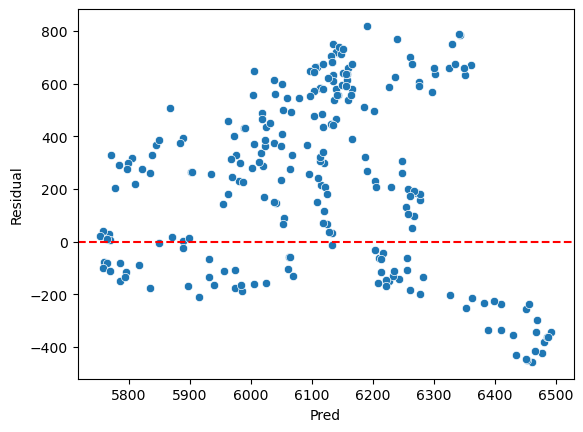

In [31]:
regression_results(test_results['y'], test_results['yhat'])

In [32]:
# check if residuals have a mean close to 0

from scipy.stats import ttest_1samp

t_stat, p_value = ttest_1samp(test_results['residuals'], 0)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value > alpha:
    print("Fail to reject H0: Residual mean is not significantly different from 0 (good model).")
else:
    print("Reject H0: Residual mean is significantly different from 0 (model may be biased).")

T-statistic: 11.0581
P-value: 0.0000
Reject H0: Residual mean is significantly different from 0 (model may be biased).


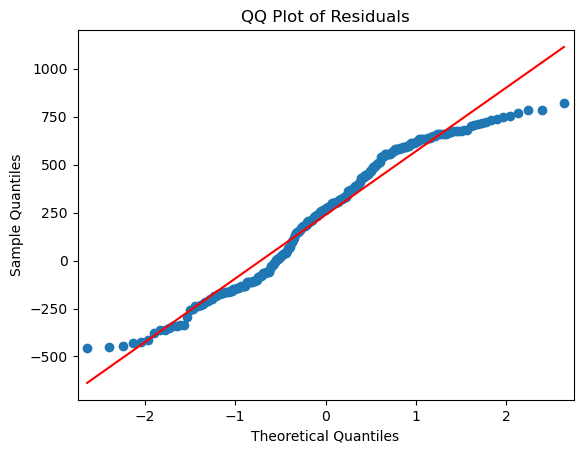

In [33]:
import statsmodels.api as sm

# QQ Plot
sm.qqplot(test_results['residuals'], line='s')
plt.title("QQ Plot of Residuals")
plt.show()

**Insights**
- $P-value$ lower than 0.05 for T-Test for residual mean indicate that the residual mean is significantly different from 0 (model may be biased)
- Residuals are not normally distributed

### Predicting Stock Price into the Future (90 Days)

With the best hyperparameters plugged into the `Prophet` model, it is now possible to train the `Prophet` model on the entire dataset and predict the future stock price of INDF for 90 days in 2024.

In [34]:
# Train best model on entire dataset
best_model = Prophet(holidays=holidays, **results_df.iloc[0, :-2].to_dict())
best_model.fit(df)

13:44:40 - cmdstanpy - INFO - Chain [1] start processing
13:44:40 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
from datetime import datetime
from pandas.tseries.offsets import BDay  # Business Day offset

# Define the start date for predictions in early 2024
start_date = datetime(2024, 1, 2)

# Generate 90 business days (weekdays only) from start_date
future_dates = pd.date_range(start=start_date, periods=90, freq=BDay())  # BDay ensures only business days (Mon-Fri)

In [41]:
# Create a DataFrame with only trading days
future = pd.DataFrame({'ds': future_dates})

# Forecast the future stock prices 90 days into the future
forecast = best_model.predict(future)

In [42]:
import plotly.graph_objects as go

# Create a custom interactive plot
fig = go.Figure()

# Plot the training data
fig.add_trace(go.Scatter(
    x=train['ds'], 
    y=train['y'], 
    mode='markers', 
    name='Training Data'
))

# Plot the test data (if available)
fig.add_trace(go.Scatter(
    x=test['ds'], 
    y=test['y'], 
    mode='markers', 
    name='Test Data'
))

# Plot the forecast
fig.add_trace(go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat'], 
    mode='lines', 
    name='Forecast'
))

# Customize the layout
fig.update_layout(
    title="INDF Forecast",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
))

fig.show()

## Summary and Conclusion

### Summary

It has been shown that it is possible to forecast stock price using a `Prophet` model thanks to its ease-of-use, modularity, and interpretrability.

### Investor Recommendation

#### Recommendation to buy (Good Entry Points) in Early March

+ As the stock price bottoms out in the beginnning of march, it may present a good buying opportunity before the next uptrend.
+ Investors looking for long-term growth may accumulate shares if the price stabilizes above 6000.

#### Recommendation to sell (Exit Strategy) for Early to Mid January

+ If the price reaches 6500–6700 IDR, consider selling for short-term profits.

### Model Limitation

Unfortunately, using the `Prophet` model has also come with some limitations, which are:
1. **Failure to Capture Market Efficiency & Random Walk** – Stock prices follow a random walk, making Prophet's deterministic trend and seasonality assumptions ineffective for predicting future movements.
2. **Weak Handling of External Factors & Market Sentiment** – Prophet relies solely on historical prices and struggles to integrate crucial external drivers like macroeconomic data, news, and sentiment.
3. **Poor Adaptability to Regime Shifts & Non-Stationarity** – Structural breaks (e.g., bull/bear markets) disrupt Prophet’s trend assumptions, making it unsuitable for dynamic stock market conditions.

### Model Improvement Ideas

To increase the predictive power of the model, there are some steps that can be taken to improve the model's shortcomings:

1. **Add External Regressors** – Incorporate macroeconomic indicators, trading volume, interest rates, or sentiment data to provide additional predictive power beyond historical prices.
2. **Use Shorter Time Horizons** – Limit forecasting to short-term trends where seasonality and momentum effects may still hold some relevance, reducing long-term uncertainty.
3. **Apply Post-Processing Adjustments** – Use statistical corrections or smoothing techniques to adjust forecasts based on recent market conditions and volatility changes.

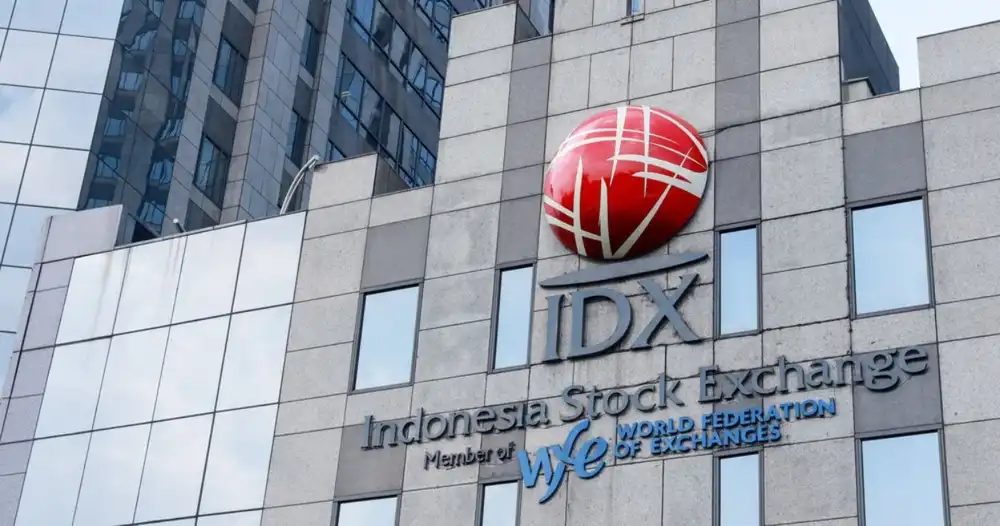